Kevin Markham best practices, following [this](https://www.youtube.com/watch?v=dPwLlJkSHLo) talk.

In [288]:
import pandas as pd
path = 'https://raw.githubusercontent.com/justmarkham/pycon-2019-tutorial/master/ted.csv'
ted = pd.read_csv(path)

In [129]:
ted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  url                 2550 non-null   object
 16  views               2550

In [130]:
ted.isna().sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
film_year             0
dtype: int64

## Which talks provoke the most online discussion?

We can rank the talks by number of comments, normalised by the number of views.

In [131]:
ted['views_per_comment'] = ted.views / ted.comments

ted.sort_values('views_per_comment')[['name', 'views_per_comment']].head()

,name,views_per_comment
744,Diane J. Savino: The case for same-sex marriage,450.531587
803,David Bismark: E-voting without fraud,651.739808
96,Richard Dawkins: Militant atheism,683.134291
694,Sharmeen Obaid-Chinoy: Inside a school for sui...,703.886818
954,Janet Echelman: Taking imagination seriously,735.525682


## Visualise the distribution of comments

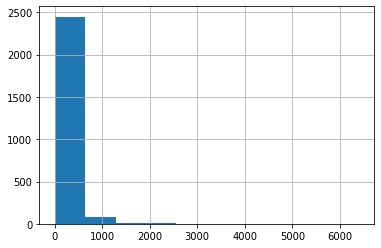

In [132]:
ted.comments.hist();

In [133]:
ted[ted.comments >= 1500].shape

(17, 19)

Most talks have fewer than 1500 comments (only 17 have more), so I drop the ones that have more. I initially tried to avoid this, but as Keving points out in the video: plotting entails decision making, as a plot is a summary of your data and not a representation of all your data. This is a good lesson to take away from this.

Use query to filter data

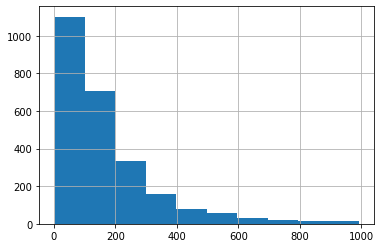

In [134]:
ted.query('comments < 1000').comments.hist();

Use indexing to filter

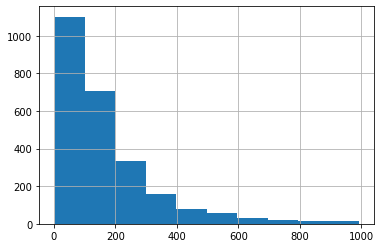

In [135]:
ted[ted.comments < 1000].comments.hist();

Use loc to filter, which is considered best practice

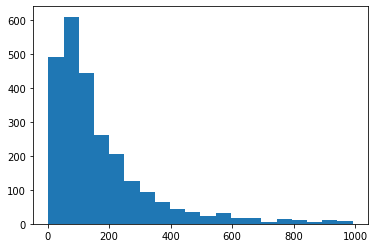

In [136]:
ted.loc[ted.comments < 1000, 'comments'].hist(bins=20, grid=False);

## Plot the number of talks that took place each year

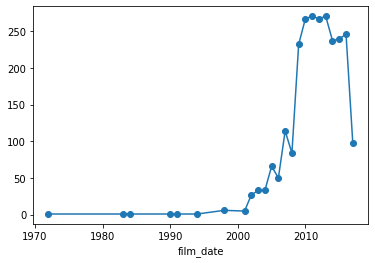

In [137]:
film_year = pd.to_datetime(ted.film_date, unit='s').dt.year
ted.groupby(film_year).size().plot(marker='o');

Alternative approach (no need to group data first, here)

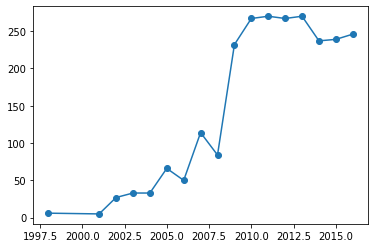

In [138]:
film_year[film_year.between(1997, 2016)].value_counts().sort_index().plot(marker='o');

# What were the "best" events in TED history to attend

Let's define "best" by event that had the most discussed talks, defined as talks with low view-to-comments ratio (i.e. talks for which people were likely to leave comments), as used above.

In [206]:
df = (ted.groupby('event')
      .agg({'views_per_comment':[('total', 'sum'), ('talks', 'count')]})
      .droplevel(level=0, axis=1)
      .reset_index())

df = df[df.talks >= 10]

df['weighted_sum'] = df.total / df.talks
df.sort_values('weighted_sum')[:10]

,event,total,talks,weighted_sum
97,TEDGlobal 2010,286404.503200,55,5207.354604
135,TEDWomen 2010,190844.942208,34,5613.086536
106,TEDIndia 2009,212406.277338,35,6068.750781
24,Mission Blue Voyage,109437.301134,18,6079.850063
60,TED2010,416144.893485,68,6119.777845
93,TEDCity2.0,81633.440301,11,7421.221846
9,EG 2007,97900.518061,13,7530.809082
98,TEDGlobal 2011,518812.975335,68,7629.602578
95,TEDGlobal 2007,214516.379586,27,7945.051096
61,TED2011,574975.371702,70,8213.933881


Above is somewhat embarassing, as I'm manually, and unnecessarily, calculate the mean. Simpler approach, focusing on total views, rather than normalised comments.

In [222]:
(ted.groupby('event').views
 .agg(['mean', 'count', 'sum'])
 .sort_values('sum', ascending=False)[:5])

,mean,count,sum
event,,,
TED2013,2.302700e+06,77,177307937
TED2014,2.072874e+06,84,174121423
TEDGlobal 2013,2.584163e+06,66,170554736
TED2015,2.011017e+06,75,150826305
TED2006,3.274345e+06,45,147345533


# Unpack the ratings data

In [235]:
import ast  # abstract syntax tree

In [238]:
ast.literal_eval('[1, 2, 3]')

[1, 2, 3]

In [277]:
pieces = []

for talk in range(len(ted.index)):
    ratings = ted.loc[talk, 'ratings']
    talk_name = ted.loc[talk, 'name']
    
    frame = pd.DataFrame(ast.literal_eval(ratings))
    frame['talk_name'] = talk_name
    
    pieces.append(frame)
    
ratings = pd.concat(pieces)
ratings.head()

,id,name,count,talk_name
0,7,Funny,19645,Ken Robinson: Do schools kill creativity?
1,1,Beautiful,4573,Ken Robinson: Do schools kill creativity?
2,9,Ingenious,6073,Ken Robinson: Do schools kill creativity?
3,3,Courageous,3253,Ken Robinson: Do schools kill creativity?
4,11,Longwinded,387,Ken Robinson: Do schools kill creativity?


Alternative

In [296]:
ted.ratings = ted.ratings.apply(ast.literal_eval)

pieces = []

for talk in range(len(ted.index)):
    ratings = ted.loc[talk, 'ratings']
    talk_name = ted.loc[talk, 'name']
    
    frame = pd.DataFrame(ratings)
    frame['talk_name'] = talk_name
    
    pieces.append(frame)
    
ratings = pd.concat(pieces)
ratings.head()

,id,name,count,talk_name
0,7,Funny,19645,Ken Robinson: Do schools kill creativity?
1,1,Beautiful,4573,Ken Robinson: Do schools kill creativity?
2,9,Ingenious,6073,Ken Robinson: Do schools kill creativity?
3,3,Courageous,3253,Ken Robinson: Do schools kill creativity?
4,11,Longwinded,387,Ken Robinson: Do schools kill creativity?


In [276]:
ratings.head()

,id,name,count,talk_name
0,7,Funny,19645,Ken Robinson: Do schools kill creativity?
1,1,Beautiful,4573,Ken Robinson: Do schools kill creativity?
2,9,Ingenious,6073,Ken Robinson: Do schools kill creativity?
3,3,Courageous,3253,Ken Robinson: Do schools kill creativity?
4,11,Longwinded,387,Ken Robinson: Do schools kill creativity?


# Count total number of ratings received by each talk

In [334]:
%%timeit
def count_ratings(ratings):   
    return pd.DataFrame(ratings)['count'].sum()


ted['count_ratings'] = ted.ratings.apply(count_ratings)
ted.sort_values('count_ratings', ascending=False).name[:5]

1.53 s ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Alternative that's much faster!

In [333]:
%%timeit
def get_num_ratings(list_of_dicts):
    count = 0
    for d in list_of_dicts:
        count += d['count']
    return count 
ted['count_ratings'] = ted.ratings.apply(get_num_ratings)
ted.sort_values('count_ratings', ascending=False).name[:5]

6.33 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
